In [20]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.offsetbox as offsetbox
from scipy.stats import linregress
import os
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
from scipy import ndimage

In [2]:
# Dictionary of standard (LEADER) model colours
col_dict = {'ACCESS-ESM1-5':'#7f3c8d','CanESM5':'#11a579','CMCC-CM2-SR5':'#3969ac','CNRM-CM6-1':'red','FGOALS-g3':'#f2b701','GISS-E2-1-G':'#e73f74','HadGEM3-GC31-LL':'#80ba5a','IPSL-CM6A-LR':'#e68310','MIROC6':'#008695','MPI-ESM1-2-LR':'#cf1c90','NorESM2-LM':'#f97b72'}
exp_col_dict = {"hist-totalO3": "#66c5cc",
	"hist-sol": 	"#f6cf71",
	"hist-volc":	"#f89c74",
	"unlabeled_1":  "#dcb0f2",  # rename if needed    
	"hist-aer": 	"#87c55f",
	"unlabeled_2":  "#9eb9f3",  # rename if needed
	"hist-GHG": 	"#fe88b1",
	"hist-nat": 	"#c9db74",
	"hist-total03":  "#8be0a4",  # rename if needed    
	"historical":   "#b497e7",
	"observations": "#b3b3b3"
}

In [3]:
def calculate_NAO_trend(ds, year_init, year_final, period_init, variable, time_variable):

    #creating an empty array for the trend which will be appended to and then outputted
    #got to convert into amount of years between, there is a +1 due to python's indexing finishing before the last one (I want to include 0 and end)
    #not currently outputting the intercept but could I I need it
    NAO_trend_slope = np.zeros(year_final - year_init - period_init)
    NAO_trend_intercept = np.zeros(year_final - year_init - period_init)
    
    #opening dataset
    #ds = xr.open_dataset(filepath)
    
    period_end = (year_init + period_init)
    trend_period = period_init
    i = 0

    while period_end < year_final:
        #Taking slice of dataset to perform the linregress on
        ds_slice = ds[variable].sel({time_variable: slice(year_init,year_init+trend_period)}).values
        
        # time as a simple integer array, the +1 comes from matching to the line above when slicing between initial year and initial year + trend period.        
        time_numeric = np.arange(trend_period+1)

        # Perform the regression using linregress (returns slope, intercept, r_value, p_value, std_err)
        reg_slope, reg_intercept, _, _, _ = linregress(time_numeric, ds_slice)
    
        # Store the results within the arrays made earlier
        NAO_trend_slope[i] = reg_slope
        NAO_trend_intercept[i] = reg_intercept

        #increasing the enddate, trend_period ( to update the numeric time array) and the index i.
        period_end = period_end + 1
        trend_period = trend_period + 1
        i = i + 1
        

    return NAO_trend_slope

def get_ensemble_means_timeseries_files(folder_path):
    #function which will loop through a folder (my folders are by experiment) to find all the relevant EM files
    ens_means_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if '_EM_' in filename]
    return ens_means_files

def get_multimodel_mean(files, variable):
    #this will open each file within files (list)
    #then calculate the mean across them (multimodel mean)
    #then it will output this data as an array

    data_arrays = []
    
    #looping over all files
    for file in files:
        #opening the dataset for one file
        ds = xr.open_dataset(file, engine='netcdf4')

        #appending the timeseries data to the array
        data_arrays.append(ds[variable])

    #calculating the mean
    multimodel_mean = np.mean([da.values for da in data_arrays], axis=0)

    #creating an array of the mean
    multimodel_da = xr.DataArray(multimodel_mean, coords=data_arrays[0].coords, dims=data_arrays[0].dims)

    return multimodel_da


In [4]:
#Want to open the dataset and then change the start years. Then change the end years - but need them kinda both changing at th same time.
#Yeah so change the start year loop and within that the change the end year loop.
#acall function. Get trend value returned
#save this to a datasturcture (ensembles, start year (1951-2013), end year (1952-2014))

variable = 'psl'
model = ['HadGEM3-GC31-LL']
start_years = np.arange(1951, 2014)
end_year = 2015
end_years = np.arange(1952,2015)
ensemble_trends = []
model_trend_list = []

for m in model:
    #looping through each model to find the filenames of the nao timeseries for each ensemble member and ensemble_mean
    folderpath = '/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAO/historical/' + m + '/'
    filepaths = [os.path.join(folderpath, filename) for filename in os.listdir(folderpath) if m in filename and '_EM_' not in filename]# and'r11i1' in filename]
    for f in filepaths:
        #looping through each ensembles filepath name for that model
        ds = xr.open_dataset(f)
        trend_matrix = np.full((len(start_years), len(end_years)), np.nan)
        
        for i, start in enumerate(start_years):
            valid_end_mask = end_years > start

            try:
                trend = calculate_NAO_trend(ds,start,end_year,1, variable, 'year')
                if trend.shape[0] != valid_end_mask.sum():
                    raise ValueError(f"Expected {valid_end_mask.sum()} trends, got {trend.shape[0]}")
                trend_matrix[i, valid_end_mask] = trend * 10

            except Exception as e:
                print(f"Trend calc failed for {f}, start={start}: {e}")

        ensemble_trends.append(trend_matrix)


ensemble_ids = [f"ens_{i}" for i in range(len(ensemble_trends))]

trend_da = xr.DataArray(
    data=np.array(ensemble_trends),  # shape: (ensemble, start_year, end_year)
    dims=["ensemble", "start_year", "end_year"],
    coords={
        "ensemble": ensemble_ids,
        "start_year": start_years,
        "end_year": end_years
    },
    name="nao_trend"
)
#models = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']#for historical - removed GISS as issues with time on that one.

#trend_da.to_netcdf('/gws/nopw/j04/extant/users/slbennie/NA_WG_trend_sensitivty.nc')

In [5]:
import os
import numpy as np
import xarray as xr

variable = 'psl'
models = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']#for historical - removed GISS as issues with time on that one.
start_years = np.arange(1951, 2014)
end_years = np.arange(1952, 2015)

# To collect model-wise data
model_trend_data = []
max_ensemble_count = 0

for model in models:
    folderpath = f'/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAO/historical/{model}/'
    filepaths = sorted([os.path.join(folderpath, f) for f in os.listdir(folderpath) if model in f and '_EM_' not in f])

    model_ensemble_trends = []

    for filepath in filepaths:
        ds = xr.open_dataset(filepath)
        trend_matrix = np.full((len(start_years), len(end_years)), np.nan)

        for i, start in enumerate(start_years):
            valid_end_mask = end_years > start
            try:
                trend = calculate_NAO_trend(ds, start, 2015, 1, variable, 'year')

                if trend.shape[0] != valid_end_mask.sum():
                    raise ValueError(f"Expected {valid_end_mask.sum()} trends, got {trend.shape[0]}")

                trend_matrix[i, valid_end_mask] = trend * 10

            except Exception as e:
                print(f"Trend calc failed for {filepath}, start={start}: {e}")

        model_ensemble_trends.append(trend_matrix)

    # Keep track of max ensemble count for padding
    max_ensemble_count = max(max_ensemble_count, len(model_ensemble_trends))

    # Store per model
    model_trend_data.append(np.array(model_ensemble_trends))


# Pad each model's ensemble data to match max_ensemble_count
#basically outting in 0 for ensemble members that don't eist.
padded_model_data = []
for trends in model_trend_data:
    if trends.shape[0] < max_ensemble_count:
        pad_width = ((0, max_ensemble_count - trends.shape[0]), (0, 0), (0, 0))
        trends = np.pad(trends, pad_width, constant_values=np.nan)
    padded_model_data.append(trends)

# Final array: shape (model, ensemble, start_year, end_year)
trend_array = np.stack(padded_model_data)

trend_da = xr.DataArray(
    data=trend_array,
    dims=["model", "ensemble", "start_year", "end_year"],
    coords={
        "model": models,
        "ensemble": np.arange(max_ensemble_count),
        "start_year": start_years,
        "end_year": end_years
    },
    name="nao_trend"
)

# Save if needed
trend_da.to_netcdf('/gws/nopw/j04/extant/users/slbennie/NA_WG_trend_sensitivity_by_model.nc')


In [6]:
#ERA5 trend sensitivty to start date!!!
variable = 'nao_timeseries_djf'
start_years = np.arange(1951, 2014)
end_year = 2015
end_years = np.arange(1952,2015)
era5_trends = []

era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/ERA5_2020/ERA5_1.cvdp_data.1940-2020.nc')

era5_trend_matrix = np.full((len(start_years), len(end_years)), np.nan)

for i, start in enumerate(start_years):
    valid_end_mask = end_years > start
    try:
        era5_trend = calculate_NAO_trend(era5, start, end_year, 1, variable, 'TIME')
        if era5_trend.shape[0] != valid_end_mask.sum():
            raise ValueError(f"Expected {valid_end_mask.sum()} trends, got {era5_trend.shape[0]}")
        era5_trend_matrix[i, valid_end_mask] = era5_trend * 10

    except Exception as e:
        print(f"Trend calc failed for {f}, start={start}: {e}")

era5_trends.append(era5_trend_matrix)

era5_ids = [f"ens_{i}" for i in range(len(era5_trends))]

era5_trend_da = xr.DataArray(
    data=np.array(era5_trends),  # shape: (ensemble, start_year, end_year)
    dims=["ensemble", "start_year", "end_year"],
    coords={
        "ensemble": era5_ids,
        "start_year": start_years,
        "end_year": end_years
    },
    name="nao_trend_era5"
)

#era5_trend_da.to_netcdf('/gws/nopw/j04/extant/users/slbennie/era5_NA_WG_NAO_index_trend_sensitivity.nc')
print(era5_trend_da)

# Broadcast start_year and end_year to match the 2D grid
start, end = xr.broadcast(era5_trend_da.start_year, era5_trend_da.end_year)

# Create the boolean mask where end_year - start_year > 20
long_period_mask = (end - start) > 20

masked_trends = era5_trend_da.where(long_period_mask)

<xarray.DataArray 'nao_trend_era5' (ensemble: 1, start_year: 63, end_year: 63)> Size: 32kB
array([[[ 10.15359133,   0.56603536,   0.66421603, ...,   0.14083761,
           0.12473351,   0.12916241],
        [         nan,  -9.02152061,  -2.46618219, ...,   0.14197179,
           0.12531162,   0.12986277],
        [         nan,          nan,   4.08915624, ...,   0.16019208,
           0.14238829,   0.14653539],
        ...,
        [         nan,          nan,          nan, ...,  23.28857303,
           1.36672825,   2.76844287],
        [         nan,          nan,          nan, ...,          nan,
         -20.55511653,  -3.60436231],
        [         nan,          nan,          nan, ...,          nan,
                  nan,  13.34639192]]])
Coordinates:
  * ensemble    (ensemble) <U5 20B 'ens_0'
  * start_year  (start_year) int64 504B 1951 1952 1953 1954 ... 2011 2012 2013
  * end_year    (end_year) int64 504B 1952 1953 1954 1955 ... 2012 2013 2014


In [7]:
#providing the list of models (each model has its own folder with the ensemble and ensemble mean data)
model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']#for historical - removed GISS as issues with time on that one.

#Basically use the same function as before but want only to longest trend period. Make period_init biggest it can be.
year_init = 1951
year_final = 2015
period_init = year_final - year_init - 1
time = np.arange(year_init+period_init, year_final)

variable = 'nao_timeseries_djf'
ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/ERA5_2020/ERA5_1.cvdp_data.1940-2020.nc')
era5_trend_PDF = calculate_NAO_trend(ds, year_init, year_final, 63, variable, 'TIME') * 10

ensembles_trend_PDF = {}
variable = 'psl'

for m in model:
    #looping through each model to find the filenames of the nao timeseries for each ensemble member and ensemble_mean
    folderpath = '/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAO/historical/' + m + '/'
    filepaths = [os.path.join(folderpath, filename) for filename in os.listdir(folderpath) if m in filename and '_EM_' not in filename]

    #finding the longest trend and then appending this to the data structure
    ensembles_trend_PDF[m] = []
    for i in range(0,len(filepaths)):
        ds = xr.open_dataset(filepaths[i])
        trend_PDF = calculate_NAO_trend(ds,year_init, year_final, period_init, variable, 'year')
        ensembles_trend_PDF[m].append(trend_PDF.item() * 10)

#finding the max and mins of all the data to then create good bins.
all_data = [slope for slopes in ensembles_trend_PDF.values() for slope in slopes]
data_min = min(all_data)  # Minimum value in the data
data_max = max(all_data)  # Maximum value in the data

# Define the number of bins you want
num_bins = 25

# Calculate the bin edges with equal width
bin_edges = np.linspace(data_min, data_max, num_bins + 1)  # +1 because bin_edges has one more edge than bins

# Create an array to accumulate the data for the stacked histogram
hist_data = []
colors = []  # Store colors for each model

for m in model:
    hist, _ = np.histogram(ensembles_trend_PDF[m], bins=bin_edges)
    hist_data.append(hist)
    colors.append(col_dict[m])

hist_data = np.array(hist_data)

In [8]:
print(np.max(masked_trends), np.min(masked_trends))

<xarray.DataArray 'nao_trend_era5' ()> Size: 8B
array(0.7750402) <xarray.DataArray 'nao_trend_era5' ()> Size: 8B
array(-0.88438854)


In [33]:
import numpy as np

def outline_from_mask(mask, x_coords, y_coords, ax, **plot_kwargs):
    """
    Draw a thin stepped outline around valid data cells in `mask`.
    mask: 2D boolean array (True = data).
    x_coords: 1D array of start_year (cell centers).
    y_coords: 1D array of end_year (cell centers).
    """
    ny, nx = mask.shape

    # Build edges from centers (len+1)
    x_edges = np.concatenate(([x_coords[0] - 0.5], 0.5*(x_coords[1:] + x_coords[:-1]), [x_coords[-1] + 0.5]))
    y_edges = np.concatenate(([y_coords[0] - 0.5], 0.5*(y_coords[1:] + y_coords[:-1]), [y_coords[-1] + 0.5]))

    # Loop over cells and draw only those edges that border no-data
    for j in range(ny):
        for i in range(nx):
            if not mask[j,i]:
                continue
            # left edge
            if i == 0 or not mask[j, i-1]:
                ax.plot([x_edges[i], x_edges[i]], [y_edges[j], y_edges[j+1]], **plot_kwargs)
            # right edge
            if i == nx-1 or not mask[j, i+1]:
                ax.plot([x_edges[i+1], x_edges[i+1]], [y_edges[j], y_edges[j+1]], **plot_kwargs)
            # bottom edge
            if j == 0 or not mask[j-1, i]:
                ax.plot([x_edges[i], x_edges[i+1]], [y_edges[j], y_edges[j]], **plot_kwargs)
            # top edge
            if j == ny-1 or not mask[j+1, i]:
                ax.plot([x_edges[i], x_edges[i+1]], [y_edges[j+1], y_edges[j+1]], **plot_kwargs)

    return ax


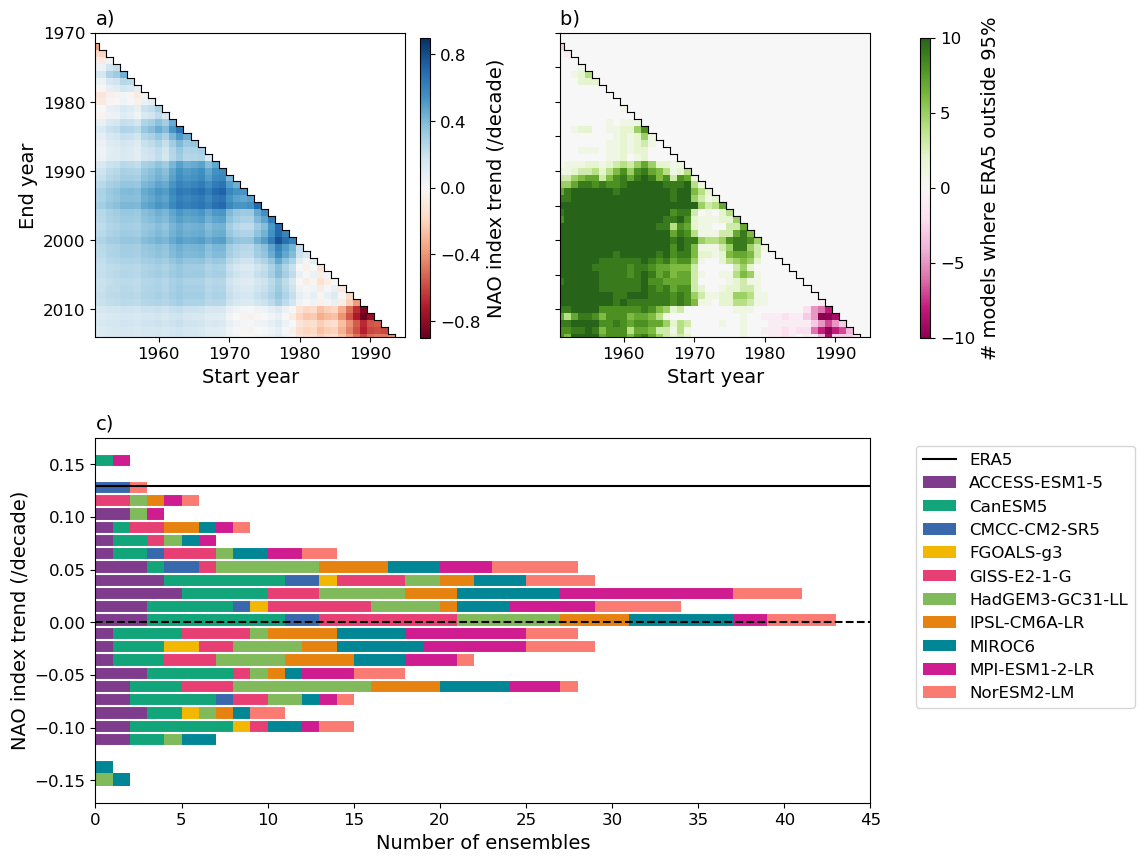

In [41]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2,2, height_ratios=[1,1.2], hspace=0.3, wspace=0.5)

#top row - the triangle plots
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

#bottom row- histogram
ax3 = fig.add_subplot(gs[1,:])


#a) ERA5 trends across 1951-2014
levels = np.arange(-0.9,0.905, 0.005)  # 0 through 10 models
cmap = plt.get_cmap("RdBu", len(levels) - 1)
norm = TwoSlopeNorm(vmin=-0.9, vcenter=0, vmax=0.9)

img1 = masked_trends.transpose("ensemble", "end_year", "start_year").plot(ax=ax1, cmap=cmap, norm=norm, add_colorbar=False, add_labels=False)

data_a = masked_trends.isel(ensemble=0).transpose("end_year","start_year")
mask_a = data_a.notnull().values

ax1 = outline_from_mask(mask_a, data_a["start_year"].values, data_a["end_year"].values,
                        ax1, color="k", linewidth=0.8)

ax1.set_xlim(1951,1995)
ax1.set_ylim(1970,2014)
ax1.invert_yaxis()
ax1.set_title('a)', loc='left', fontsize=14)
ax1.set_xlabel('Start year', fontsize=14)
ax1.set_ylabel('End year', fontsize=14)
ax1.set_yticks(np.arange(1970,2020,10))
ax1.tick_params(labelsize=12)



cax = fig.add_axes([0.45, 0.575, 0.01, 0.3])
ticks = (-0.8,-0.4,0,0.4,0.8)
cbar1 = fig.colorbar(img1, cax=cax, ticks=ticks, orientation="vertical")
cbar1.set_label("NAO index trend (/decade)", fontsize=14)
cbar1.ax.tick_params(labelsize=12)
cbar1.ax.yaxis.set_ticks_position('right')      # ← Move ticks to right
cbar1.ax.yaxis.set_label_position('right')      # ← Ensure label is also on the right
cbar1.ax.tick_params(which="minor", length=0)


#b) ERA5 outwith models' ensemble spread?
models = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
trend = trend_da.where(long_period_mask)

tally_mask = xr.DataArray(
    np.zeros_like(era5_trend_da.sel(ensemble='ens_0').values, dtype=int),
    coords=era5_trend_da.sel(ensemble='ens_0').coords,
    dims=["start_year", "end_year"],
    name="era5_within_model_bounds_count"
)

for m in models:
    #selecting one model
    model_data = trend.sel(model=m)

    #finding the max and mins
    max_trends = model_data.max(dim='ensemble')
    min_trends = model_data.min(dim='ensemble')

    #finding the 2.5-97.5% for this model
    lower = min_trends + (2.5 * ((max_trends - min_trends)/100))
    upper = max_trends - (2.5 * ((max_trends - min_trends)/100))

    # Remove the "ensemble" dimension from ERA5 to align with lower/upper
    era5_data = era5_trend_da.sel(ensemble='ens_0')

    # Create mask: True where ERA5 trend lies within bounds and one for ERA5 outwith bounds
    #within_bounds = (era5_data > lower) & (era5_data < upper)
    #outwith_bounds = (era5_data < lower) | (era5_data > upper)

    #this mask +1 when era5 above and -1 when era5 below (assuming basically that all model trends underestimate era5)
    
    above = (era5_data > upper).fillna(False).astype(int)
    below = (era5_data < lower).fillna(False).astype(int)

    # Tally up where ERA5 is within model's range
    #tally_mask = tally_mask + outwith_bounds.fillna(False).astype(int)
    tally_mask = tally_mask + above - below


levels = np.arange(-10, 11,0.1)  # 0 through 10 models
cmap = plt.get_cmap("PiYG", len(levels) - 1)
norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10)

img2 = tally_mask.transpose("end_year","start_year").plot(cmap=cmap, norm=norm, ax=ax2, add_colorbar=False, add_labels=False)


cax = fig.add_axes([0.95, 0.575, 0.01, 0.3])
cbar2 = fig.colorbar(img2, cax=cax, ticks=[-10,-5,0,5,10], orientation='vertical')
cbar2.set_label("# models where ERA5 outside 95%", fontsize=14)
cbar2.ax.tick_params(labelsize=12)

ax2 = outline_from_mask(
    mask_a,   # <- same mask as panel a
    data_b["start_year"].values,
    data_b["end_year"].values,
    ax2,
    color="k", linewidth=0.8
)
ax2.set_title("b) ", loc='left', fontsize=14)
ax2.set_xlim(1951,1995)
ax2.set_ylim(1970,2014)
ax2.invert_yaxis()
ax2.set_xlabel('Start year', fontsize=14)
ax2.tick_params(labelsize=12)
ax2.set_ylabel("")
ax2.set_yticklabels([])
#ax2.yaxis.set_visible(False)

#Plot c) 1951-2014 trends of models and era5 - histogram
for i in range(0, len(hist_data)):
    ax3.barh(bin_edges[:-1], hist_data[i], height=np.diff(bin_edges), left=hist_data[:i].sum(axis=0), color=colors[i], label=model[i])
    ax3.barh(bin_edges[:-1], hist_data[i], height=np.diff(bin_edges), left=hist_data[:i].sum(axis=0), color=colors[i])

bin_width = np.abs(bin_edges[0]-bin_edges[1])

#plotting the trend hisogram
for i in range(1,len(bin_edges)):
    ax3.axhline(bin_edges[i]+bin_width/2, color='white')

#plotting ERA5
ax3.axhline(era5_trend_PDF.item(), color='black', label='ERA5')
ax3.axhline(0, color='black', linestyle='--')

ax3.set_xlim(0,45)

#creates a legend outwith the plots
a = ax3.legend(loc='upper center', bbox_to_anchor=(1.2, 1), ncols=1, fontsize=12)

ax3.set_title('c)', loc='left',fontsize=14)
ax3.set_xlabel('Number of ensembles', fontsize=14)
ax3.set_ylabel('NAO index trend (/decade)', fontsize=14)
ax3.tick_params(labelsize=12)

plt.savefig('NA_WG_final_trend_sens&histogram_1951-2014.png', bbox_inches='tight')

plt.show()

/tmp/ipykernel_558/1415301550.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


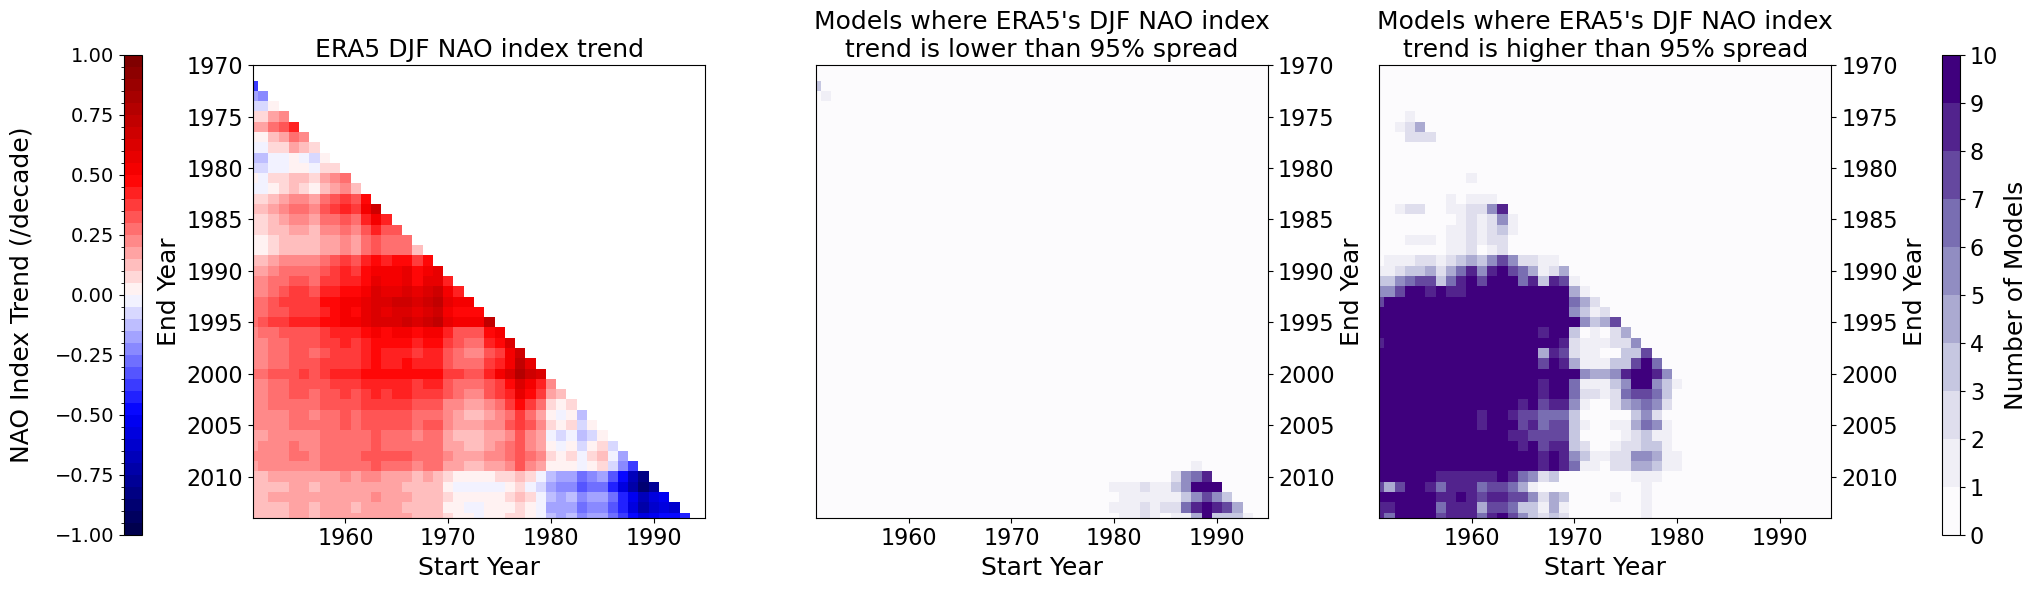

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

#a) ERA5 trends across 1951-2014
levels = np.arange(-1,1.025, 0.05)  # 0 through 10 models
cmap = plt.get_cmap("seismic", len(levels) - 1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

img1 = masked_trends.transpose("ensemble", "end_year", "start_year").plot(ax=ax[0], cmap=cmap, norm=norm, add_colorbar=False)

ax[0].set_xlim(1951,1995)
ax[0].set_ylim(1970,2014)
ax[0].invert_yaxis()
ax[0].set_title('ERA5 DJF NAO index trend', fontsize=18)
ax[0].set_xlabel('Start Year', fontsize=18)
ax[0].set_ylabel('End Year', fontsize=18)
ax[0].tick_params(labelsize=16)

cax = fig.add_axes([-0.01, 0.1, 0.01, 0.8])

cbar1 = fig.colorbar(img1, cax=cax, orientation="vertical")
cbar1.set_label("NAO Index Trend (/decade)", fontsize=18, rotation=90, labelpad=15)
cbar1.ax.tick_params(labelsize=14)
cbar1.ax.yaxis.set_ticks_position('left')      # ← Move ticks to left
cbar1.ax.yaxis.set_label_position('left')      # ← Ensure label is also on the left

#b) ERA5 outwith models' ensemble spread?
models = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
trend = trend_da.where(long_period_mask)

tally_mask1 = xr.DataArray(
    np.zeros_like(era5_trend_da.sel(ensemble='ens_0').values, dtype=int),
    coords=era5_trend_da.sel(ensemble='ens_0').coords,
    dims=["start_year", "end_year"],
    name="era5_within_model_bounds_count"
)

tally_mask2 = xr.DataArray(
    np.zeros_like(era5_trend_da.sel(ensemble='ens_0').values, dtype=int),
    coords=era5_trend_da.sel(ensemble='ens_0').coords,
    dims=["start_year", "end_year"],
    name="era5_within_model_bounds_count"
)


for m in models:
    #selecting one model
    model_data = trend.sel(model=m)

    #finding the max and mins
    max_trends = model_data.max(dim='ensemble')
    min_trends = model_data.min(dim='ensemble')

    #finding the 2.5-97.5% for this model
    lower = min_trends + (2.5 * ((max_trends - min_trends)/100))
    upper = max_trends - (2.5 * ((max_trends - min_trends)/100))

    # Remove the "ensemble" dimension from ERA5 to align with lower/upper
    era5_data = era5_trend_da.sel(ensemble='ens_0')

    # Create mask: True where ERA5 trend lies within bounds and one for ERA5 outwith bounds
    within_bounds = (era5_data > lower) & (era5_data < upper)
    outwith_bounds_lower = (era5_data < lower) 
    outwith_bounds_upper = (era5_data > upper)


    # Tally up where ERA5 is within model's range
    tally_mask1 = tally_mask1 + outwith_bounds_lower.fillna(False).astype(int)
    tally_mask2 = tally_mask2 + outwith_bounds_upper.fillna(False).astype(int)

levels = np.arange(0, 11,1)  # 0 through 10 models
cmap = plt.get_cmap("Purples", len(levels) - 1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

img2 = tally_mask1.transpose("end_year","start_year").plot(cmap=cmap, norm=norm, ax=ax[1], add_colorbar=False)
img3 = tally_mask2.transpose("end_year","start_year").plot(cmap=cmap, norm=norm, ax=ax[2], add_colorbar=False)

cax = fig.add_axes([1, 0.1, 0.01, 0.8])
cbar3 = fig.colorbar(img2, cax=cax, ticks=levels)
cbar3.set_label("Number of Models", fontsize=18)
cbar3.ax.tick_params(labelsize=16)

for i in range(1,3):
    ax[i].set_xlim(1951,1995)
    ax[i].set_ylim(1970,2014)
    ax[i].invert_yaxis()
    ax[i].set_xlabel('Start Year', fontsize=18)
    ax[i].set_ylabel('End Year', fontsize=18)
    ax[i].yaxis.tick_right()
    ax[i].yaxis.set_label_position("right")
    ax[i].tick_params(labelsize=16)


ax[1].set_title("Models where ERA5's DJF NAO index\ntrend is lower than 95% spread", fontsize=18)
ax[2].set_title("Models where ERA5's DJF NAO index\ntrend is higher than 95% spread", fontsize=18)

plt.tight_layout()
plt.show()

NameError: name 'ensembles_trend' is not defined

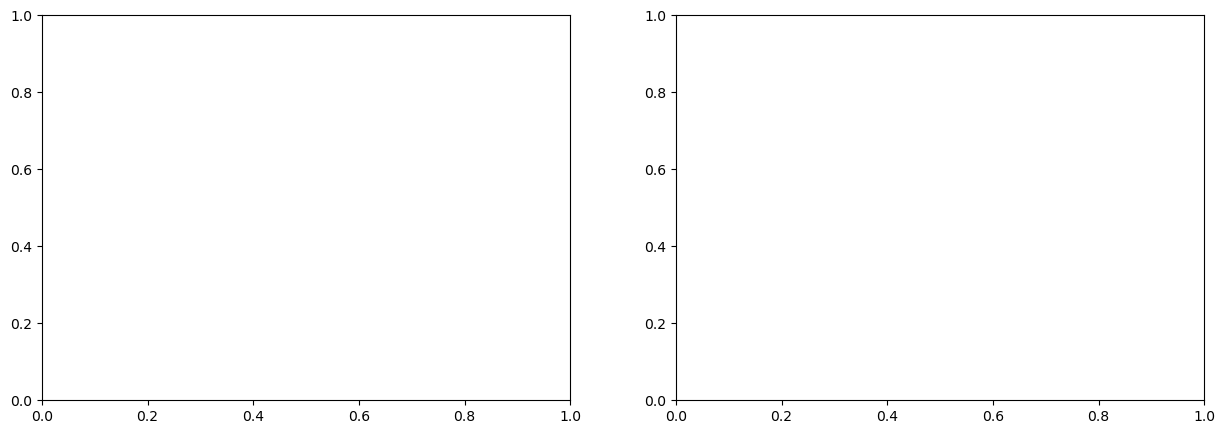

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

#FIGURE a)
#plotting ensemble trend lines and the ensemble mean trend lines
for m in model:
    for i in range(0,len(ensembles_trend[m])):
        ax[0].plot(time,ensembles_trend[m][i], color=col_dict[m], alpha=0.075)

    ax[0].plot(time,ensemble_mean_trend[m][0], label=m, color=col_dict[m])

#plotting ERA5
ax[0].plot(time, era5_trend, color='black', label='ERA5')

#FIGURE b)
for i in range(0, len(hist_data)):
    ax[1].barh(bin_edges[:-1], hist_data[i], height=np.diff(bin_edges), left=hist_data[:i].sum(axis=0), color=colors[i], label=model[i])
    ax[1].barh(bin_edges[:-1], hist_data[i], height=np.diff(bin_edges), left=hist_data[:i].sum(axis=0), color=colors[i])

bin_width = np.abs(bin_edges[0]-bin_edges[1])

#plotting the trend hisogram
for i in range(1,len(bin_edges)):
    ax[1].axhline(bin_edges[i]+bin_width/2, color='white')

#plotting ERA5
ax[1].axhline(era5_trend_PDF.item(), color='black', label='ERA5 2014')




#FORMATTING
ax[0].axhline(0, color='black', linestyle='--')
ax[1].axhline(0, color='black', linestyle='--')

ax[0].set_xlim(1980,2014)
ax[1].set_xlim(0,45)

#Titles and axis
ax[0].set_title('Trend 1951 to end year (historical)', fontsize=16)
ax[0].set_ylabel('Trend in NAO index (/decade)', fontsize=16)
ax[0].set_xlabel('Trend end year', fontsize=16)
ax[0].set_title('a)', loc='left', fontsize=16)
ax[0].tick_params(labelsize=14)

#creates a legend outwith the plots
a = ax[1].legend(loc='upper center', bbox_to_anchor=(-0.2, -0.2), ncols=6, fontsize=12)

ax[1].set_title('   PDF of trend 1951-2014 (historical)', fontsize=16)
ax[1].set_xlabel('Number of ensembles', fontsize=16)
ax[1].set_title('b)', loc='left', fontsize=16)
ax[1].tick_params(labelsize=14)

plt.suptitle('DJF NAO Index trends', fontsize=16)
#plt.tight_layout(rect=[0, 0.1, 1, 0.92])
plt.subplots_adjust(top=0.88, bottom=0.2)
plt.savefig('NAO_community_paper_plots_updated_projection_methodology/NAtlantic_group_paper_1951-2014_historical_a&b.svg', bbox_inches='tight')